# Amazon Logistics - Optimización Multinivel "El Buen Fin 2025"

## Universidad del SABES – Ingeniería Logística y Cadena de Valor  
### Campus San Felipe · Octubre 2025

**PROYECTO**: Amazon Logistics – Optimización Multinivel "El Buen Fin 2025"  
**Versión**: v3.4 _BuenFin2025_  
**Autor**: [Nombre del Estudiante]  
**Descripción**: Modelo de red de dos niveles (HUB → Ciudad) para Amazon México.

## 🔧 CONFIGURACIÓN INICIAL - EJECUTAR PRIMERO

In [1]:
# ============================================================================
# 1. INSTALACIÓN DE LIBRERÍAS
# ============================================================================
print("📦 Instalando librerías necesarias...")
!pip install pulp networkx matplotlib --quiet

# ============================================================================
# 2. IMPORTAR LIBRERÍAS
# ============================================================================
import math
import networkx as nx
import matplotlib.pyplot as plt
from pulp import *
import pandas as pd
from datetime import datetime

print("✅ Todas las librerías cargadas correctamente!")
print("🎯 Listo para optimización logística Amazon México")

📦 Instalando librerías necesarias...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 63.5 MB/s eta 0:00:00
✅ Todas las librerías cargadas correctamente!
🎯 Listo para optimización logística Amazon México


## 📊 PARÁMETROS BASE - ESCENARIO "EL BUEN FIN 2025"

In [2]:
# Capacidad de oferta por HUB (unidades)
OFERTA_BASE = {
    'CDMX_Norte': 35000,
    'Monterrey': 22000,
    'Guadalajara': 20000,
    'Queretaro': 18000,
    'Puebla': 15000,
    'Tijuana': 12000
}

# Demanda estimada por ciudad destino (unidades)
DEMANDA_BASE = {
    'Merida': 12000,
    'Cancun': 15000,
    'Toluca': 18000,
    'Leon': 14000,
    'SLP': 11000,
    'Veracruz': 13000
}

# Costos de transporte por milla (HUB → Ciudad)
COSTO_BASE_MILES = {
    'CDMX_Norte': {'Merida':142, 'Cancun':168, 'Toluca':8, 'Leon':45, 'SLP':52, 'Veracruz':48},
    'Monterrey': {'Merida':228, 'Cancun':245, 'Toluca':88, 'Leon':78, 'SLP':38, 'Veracruz':115},
    'Guadalajara': {'Merida':198, 'Cancun':215, 'Toluca':62, 'Leon':28, 'SLP':58, 'Veracruz':88},
    'Queretaro': {'Merida':158, 'Cancun':178, 'Toluca':18, 'Leon':22, 'SLP':35, 'Veracruz':52},
    'Puebla': {'Merida':128, 'Cancun':145, 'Toluca':22, 'Leon':52, 'SLP':62, 'Veracruz':28},
    'Tijuana': {'Merida':485, 'Cancun':498, 'Toluca':305, 'Leon':262, 'SLP':268, 'Veracruz':358}
}

# Parámetros económicos
COSTO_FIJO_TRAILER = 12500  # Costo fijo por trailer
PRESUPUESTO_MAX = 2_850_000  # Presupuesto máximo en MXN

print("✅ Datos base del sistema logístico cargados:")
print(f"   • {len(OFERTA_BASE)} HUBs de distribución")
print(f"   • {len(DEMANDA_BASE)} ciudades destino")
print(f"   • Presupuesto: ${PRESUPUESTO_MAX:,} MXN")

# Mostrar tablas de datos
print("\n🏭 CAPACIDAD DE HUBs:")
for hub, capacidad in OFERTA_BASE.items():
    print(f"   • {hub}: {capacidad:,} unidades")

print("\n🏙️ DEMANDA DE CIUDADES:")
for ciudad, demanda in DEMANDA_BASE.items():
    print(f"   • {ciudad}: {demanda:,} unidades")

✅ Datos base del sistema logístico cargados:
   • 6 HUBs de distribución
   • 6 ciudades destino
   • Presupuesto: $2,850,000 MXN

🏭 CAPACIDAD DE HUBs:
   • CDMX_Norte: 35,000 unidades
   • Monterrey: 22,000 unidades
   • Guadalajara: 20,000 unidades
   • Queretaro: 18,000 unidades
   • Puebla: 15,000 unidades
   • Tijuana: 12,000 unidades

🏙️ DEMANDA DE CIUDADES:
   • Merida: 12,000 unidades
   • Cancun: 15,000 unidades
   • Toluca: 18,000 unidades
   • Leon: 14,000 unidades
   • SLP: 11,000 unidades
   • Veracruz: 13,000 unidades


## 🎲 GENERADOR DE ESCENARIO PERSONALIZADO

In [3]:
def generar_escenario(XX, oferta_base, demanda_base, costo_base_miles):
    """
    Genera un escenario único basado en los últimos dígitos de matrícula

    Args:
        XX (int): Últimos dos dígitos de la matrícula
        oferta_base (dict): Capacidad base de HUBs
        demanda_base (dict): Demanda base de ciudades
        costo_base_miles (dict): Costos base de transporte

    Returns:
        tuple: (oferta_ajustada, demanda_ajustada, costos_ajustados, mod5)
    """
    # Cálculo de factores de ajuste
    mod10 = XX % 10
    mod7 = XX % 7
    mod15 = XX % 15
    mod5 = XX % 5

    # Factores de variación
    factor_demanda = 1 + mod10 / 10      # +0% a +90%
    factor_oferta = 1 + mod7 / 10        # +0% a +60%
    factor_costo = 0.85 + mod15 / 100    # -15% a +14%

    # Aplicar ajustes
    demanda_ajustada = {d: math.ceil(v * factor_demanda) for d, v in demanda_base.items()}
    oferta_ajustada = {h: math.ceil(v * factor_oferta) for h, v in oferta_base.items()}
    costos_ajustados = {h: {d: c * 1000 * factor_costo for d, c in ds.items()}
                       for h, ds in costo_base_miles.items()}

    print(f"🔢 Matrícula: {XX}")
    print(f"📈 Factores aplicados:")
    print(f"   • Demanda: +{((factor_demanda-1)*100):.0f}%")
    print(f"   • Oferta: +{((factor_oferta-1)*100):.0f}%")
    print(f"   • Costos: {((factor_costo-1)*100):+.1f}%")
    print(f"   • Restricción especial: Tipo {mod5}")

    return oferta_ajustada, demanda_ajustada, costos_ajustados, mod5

print("✅ Generador de escenario personalizado listo")

✅ Generador de escenario personalizado listo


## ⚙️ SOLVER DE OPTIMIZACIÓN HUB → CIUDAD

In [4]:
def optimizar(oferta, demanda, costos, mod5):
    """
    Resuelve el problema de optimización de transporte Amazon México

    Args:
        oferta (dict): Capacidad por HUB
        demanda (dict): Demanda por ciudad
        costos (dict): Costos de transporte
        mod5 (int): Tipo de restricción especial

    Returns:
        dict: Resultados de la optimización
    """

    # Definir conjuntos
    hubs = list(oferta.keys())
    destinos = list(demanda.keys())
    rutas = [(h, d) for h in hubs for d in destinos]

    # Crear problema de optimización
    prob = LpProblem("Amazon_BuenFin2025", LpMinimize)

    # Variables de decisión
    x = LpVariable.dicts("x", rutas, 0, cat="Integer")  # Unidades transportadas
    u = LpVariable.dicts("u", rutas, cat="Binary")       # Ruta activa (sí/no)

    # Función objetivo: Minimizar costo total
    costo_transporte = lpSum([costos[h][d] * x[(h, d)] for h, d in rutas])
    costo_fijo = lpSum([COSTO_FIJO_TRAILER * u[(h, d)] for h, d in rutas])
    prob += costo_transporte + costo_fijo

    # Restricciones de oferta (no exceder capacidad)
    for h in hubs:
        prob += lpSum(x[(h, d)] for d in destinos) <= oferta[h], f"Oferta_{h}"

    # Restricciones de demanda (satisfacer necesidad)
    for d in destinos:
        prob += lpSum(x[(h, d)] for h in hubs) >= demanda[d], f"Demanda_{d}"

    # Restricciones de activación de ruta
    for h, d in rutas:
        prob += x[(h, d)] <= max(oferta[h], demanda[d]) * u[(h, d)], f"Activacion_{h}_{d}"

    # Restricción de presupuesto
    prob += (costo_transporte + costo_fijo) <= PRESUPUESTO_MAX, "Presupuesto"

    # Restricciones especiales según matrícula
    if mod5 == 0 and 'Monterrey' in oferta:
        prob += lpSum(x[('Monterrey', d)] for d in destinos) <= 0.7 * oferta['Monterrey'], "Restriccion_Monterrey_70"
        print("   🎯 Restricción aplicada: Monterrey max 70% capacidad")

    if mod5 == 1 and 'Queretaro' in oferta:
        prob += lpSum(x[('Queretaro', d)] for d in destinos) >= 1, "Restriccion_Queretaro_min"
        print("   🎯 Restricción aplicada: Querétaro debe operar")

    if mod5 == 3 and 'CDMX_Norte' in oferta and 'Cancun' in demanda:
        prob += x[('CDMX_Norte', 'Cancun')] >= 0.3 * demanda['Cancun'], "Restriccion_CDMX_Cancun_30"
        print("   🎯 Restricción aplicada: CDMX debe surtir 30% de Cancún")

    if mod5 == 4 and 'Tijuana' in oferta:
        prob += lpSum(u[('Tijuana', d)] for d in destinos) <= 3, "Restriccion_Tijuana_max_rutas"
        print("   🎯 Restricción aplicada: Tijuana max 3 rutas")

    # Resolver el problema
    print("   🔍 Resolviendo modelo de optimización...")
    prob.solve(PULP_CBC_CMD(msg=0))

    # Recolectar resultados
    asignaciones = {(h, d): int(v.varValue) for (h, d), v in x.items() if v.varValue > 0.5}

    resultados = {
        'status': LpStatus[prob.status],
        'cost': value(prob.objective),
        'x': asignaciones,
        'util': {h: sum(asignaciones.get((h, d), 0) for d in destinos) / oferta[h] for h in hubs},
        'rutas_activas': sum(1 for v in u.values() if v.varValue > 0.5),
        'total_unidades': sum(asignaciones.values())
    }

    return resultados

print("✅ Solver de optimización listo")

✅ Solver de optimización listo


## 📈 VISUALIZACIÓN DE LA RED LOGÍSTICA

In [5]:
def graficar(resultados):
    """
    Genera visualización de la red de distribución optimizada

    Args:
        resultados (dict): Resultados de la optimización
    """

    # Crear grafo dirigido
    G = nx.DiGraph()
    pos = {}

    # Extraer nodos
    hubs = list(resultados['util'].keys())
    destinos = list({d for _, d in resultados['x'].keys()})

    # Posicionar HUBs a la izquierda
    for i, hub in enumerate(hubs):
        pos[hub] = (0, 1 - (i + 1) / (len(hubs) + 1))
        G.add_node(hub, color='blue', type='hub')

    # Posicionar destinos a la derecha
    for j, destino in enumerate(destinos):
        pos[destino] = (1, 1 - (j + 1) / (len(destinos) + 1))
        G.add_node(destino, color='orange', type='destino')

    # Agregar arcos (flujos)
    for (hub, destino), flujo in resultados['x'].items():
        G.add_edge(hub, destino, weight=flujo)

    # Configurar gráfico
    plt.figure(figsize=(16, 10))

    # Dibujar nodos
    node_colors = ['#1565c0' if G.nodes[n]['type'] == 'hub' else '#ff9900' for n in G]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=3000, alpha=0.9)

    # Dibujar etiquetas de nodos
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

    # Dibujar arcos con grosor proporcional al flujo
    if resultados['x']:
        max_flujo = max(resultados['x'].values())
        edge_widths = [2 + 6 * G.edges[u, v]['weight'] / max_flujo for u, v in G.edges()]
    else:
        edge_widths = [2] * len(G.edges())

    nx.draw_networkx_edges(G, pos, edge_color='#424242', width=edge_widths,
                          arrows=True, arrowsize=20, alpha=0.7)

    # Etiquetas de flujo en arcos
    if resultados['x']:
        edge_labels = {(u, v): f"{G.edges[u, v]['weight']:,}" for u, v in G.edges()}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    # Título y estilo
    plt.title(f"Amazon México · El Buen Fin 2025\nCosto Total: ${resultados['cost']:,.0f} MXN | {resultados['rutas_activas']} rutas activas",
              fontsize=16, fontweight='bold', pad=20)

    # Leyenda
    plt.plot([], [], 'o', color='#1565c0', markersize=10, label='HUBs de Distribución')
    plt.plot([], [], 'o', color='#ff9900', markersize=10, label='Ciudades Destino')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, fontsize=12)

    plt.axis('off')
    plt.tight_layout()
    plt.show()

print("✅ Módulo de visualización listo")

✅ Módulo de visualización listo


## 📋 GENERADOR DE REPORTE EJECUTIVO

In [6]:
def reporte_ejecutivo(resultados):
    """
    Genera reporte ejecutivo completo con análisis FODA

    Args:
        resultados (dict): Resultados de la optimización
    """

    print("=" * 70)
    print("📊 REPORTE EJECUTIVO - AMAZON MÉXICO EL BUEN FIN 2025")
    print("=" * 70)

    # Estado de la solución
    status_icon = "✅" if resultados['status'] == 'Optimal' else "⚠️"
    print(f"\n{status_icon} ESTADO DE LA SOLUCIÓN: {resultados['status']}")
    print(f"💰 COSTO TOTAL OPTIMIZADO: ${resultados['cost']:,.0f} MXN")
    print(f"📦 UNIDADES TRANSPORTADAS: {resultados['total_unidades']:,}")
    print(f"🛣️  RUTAS ACTIVAS: {resultados['rutas_activas']}")

    # Utilización por HUB
    print("\n🏭 UTILIZACIÓN POR CENTRO DE DISTRIBUCIÓN:")
    for hub, utilizacion in sorted(resultados['util'].items(), key=lambda x: x[1], reverse=True):
        if utilizacion > 0.8:
            estado = "⚡ ALTA"
            icon = "🔴"
        elif utilizacion > 0.5:
            estado = "✅ ÓPTIMA"
            icon = "🟢"
        else:
            estado = "⚠️  BAJA"
            icon = "🟡"
        print(f"   {icon} {hub:<12}: {utilizacion:>6.1%} {estado}")

    # Flujos principales
    print("\n🚚 PRINCIPALES FLUJOS DE DISTRIBUCIÓN:")
    flujos_ordenados = sorted(resultados['x'].items(), key=lambda x: x[1], reverse=True)

    if flujos_ordenados:
        for (origen, destino), unidades in flujos_ordenados[:8]:  # Top 8 flujos
            porcentaje = (unidades / resultados['total_unidades']) * 100
            print(f"   • {origen:<12} → {destino:<10}: {unidades:>6,} unidades ({porcentaje:.1f}%)")
    else:
        print("   ❌ No se encontraron flujos optimizados")

    # Métricas de eficiencia
    if resultados['total_unidades'] > 0:
        costo_por_unidad = resultados['cost'] / resultados['total_unidades']
        print(f"\n📊 MÉTRICAS DE EFICIENCIA:")
        print(f"   • Costo por unidad: ${costo_por_unidad:,.2f} MXN")
        print(f"   • Eficiencia de rutas: {resultados['rutas_activas']/len(flujos_ordenados)*100:.1f}%")

    # Análisis FODA
    print("\n" + "=" * 70)
    print("🧩 ANÁLISIS FODA - ESTRATEGIA LOGÍSTICA 2025")
    print("=" * 70)

    print("\n📍 FORTALEZAS:")
    print("   • Red flexible con ajuste automático por patrones de demanda")
    print("   • Modelo multi-HUB que minimiza costos de transporte")
    print("   • Capacidad de respuesta rápida en picos estacionales")
    print("   • Optimización matemática garantizada")

    print("\n📍 OPORTUNIDADES:")
    print("   • Implementación de IA predictiva para demanda del Buen Fin")
    print("   • Expansión a centros de distribución de último kilómetro")
    print("   • Optimización de rutas en tiempo real con machine learning")
    print("   • Integración con sistemas de inventario automatizado")

    print("\n📍 DEBILIDADES:")
    print("   • Dependencia crítica del transporte terrestre")
    print("   • Capacidad limitada en HUBs periféricos (Tijuana)")
    print("   • Sensibilidad a variaciones en costos de combustible")
    print("   • Restricciones de capacidad en temporada alta")

    print("\n📍 AMENAZAS:")
    print("   • Condiciones climáticas extremas en temporada")
    print("   • Posibles interrupciones en corredores logísticos")
    print("   • Incremento súbito en costos operativos")
    print("   • Cambios regulatorios en transporte de mercancías")

    print("\n" + "=" * 70)
    print("🎯 RECOMENDACIONES ESTRATÉGICAS:")
    print("=" * 70)
    print("   1. Implementar buffer de seguridad del 15% en HUBs críticos")
    print("   2. Desarrollar alianzas estratégicas con transportistas locales")
    print("   3. Invertir en tecnología de seguimiento en tiempo real")
    print("   4. Establecer protocolos de contingencia para clima extremo")
    print("   5. Diversificar modos de transporte (aéreo/terrestre)")
    print("   6. Implementar sistema de pronóstico de demanda con IA")

print("✅ Generador de reportes listo")

✅ Generador de reportes listo


## 🚀 EJECUCIÓN PRINCIPAL - INGRESA TU MATRÍCULA

🎯 INICIANDO SIMULACIÓN AMAZON MÉXICO - EL BUEN FIN 2025
🏢 Universidad del SABES - Ingeniería Logística y Cadena de Valor
📅 Campus San Felipe · Octubre 2025

📋 PASO 1: Generando escenario para matrícula 22...
🔢 Matrícula: 22
📈 Factores aplicados:
   • Demanda: +20%
   • Oferta: +10%
   • Costos: -8.0%
   • Restricción especial: Tipo 2

📊 RESUMEN DEL ESCENARIO:
   • Oferta total: 134,202 unidades
   • Demanda total: 99,600 unidades
   • Balance: ✅ SOSTENIBLE (Excedente: 34,602 unidades)

⚙️  PASO 2: Optimizando red logística...
   🔍 Resolviendo modelo de optimización...
❌ ALERTA: Solución Infeasible. Puede haber problemas de factibilidad.
💡 Sugerencia: Revisa las restricciones o aumenta la capacidad

📈 PASO 3: Generando reporte ejecutivo...
📊 REPORTE EJECUTIVO - AMAZON MÉXICO EL BUEN FIN 2025

⚠️ ESTADO DE LA SOLUCIÓN: Infeasible
💰 COSTO TOTAL OPTIMIZADO: $2,401,200,000 MXN
📦 UNIDADES TRANSPORTADAS: 18,000
🛣️  RUTAS ACTIVAS: 0

🏭 UTILIZACIÓN POR CENTRO DE DISTRIBUCIÓN:
   🔴 Puebla      :

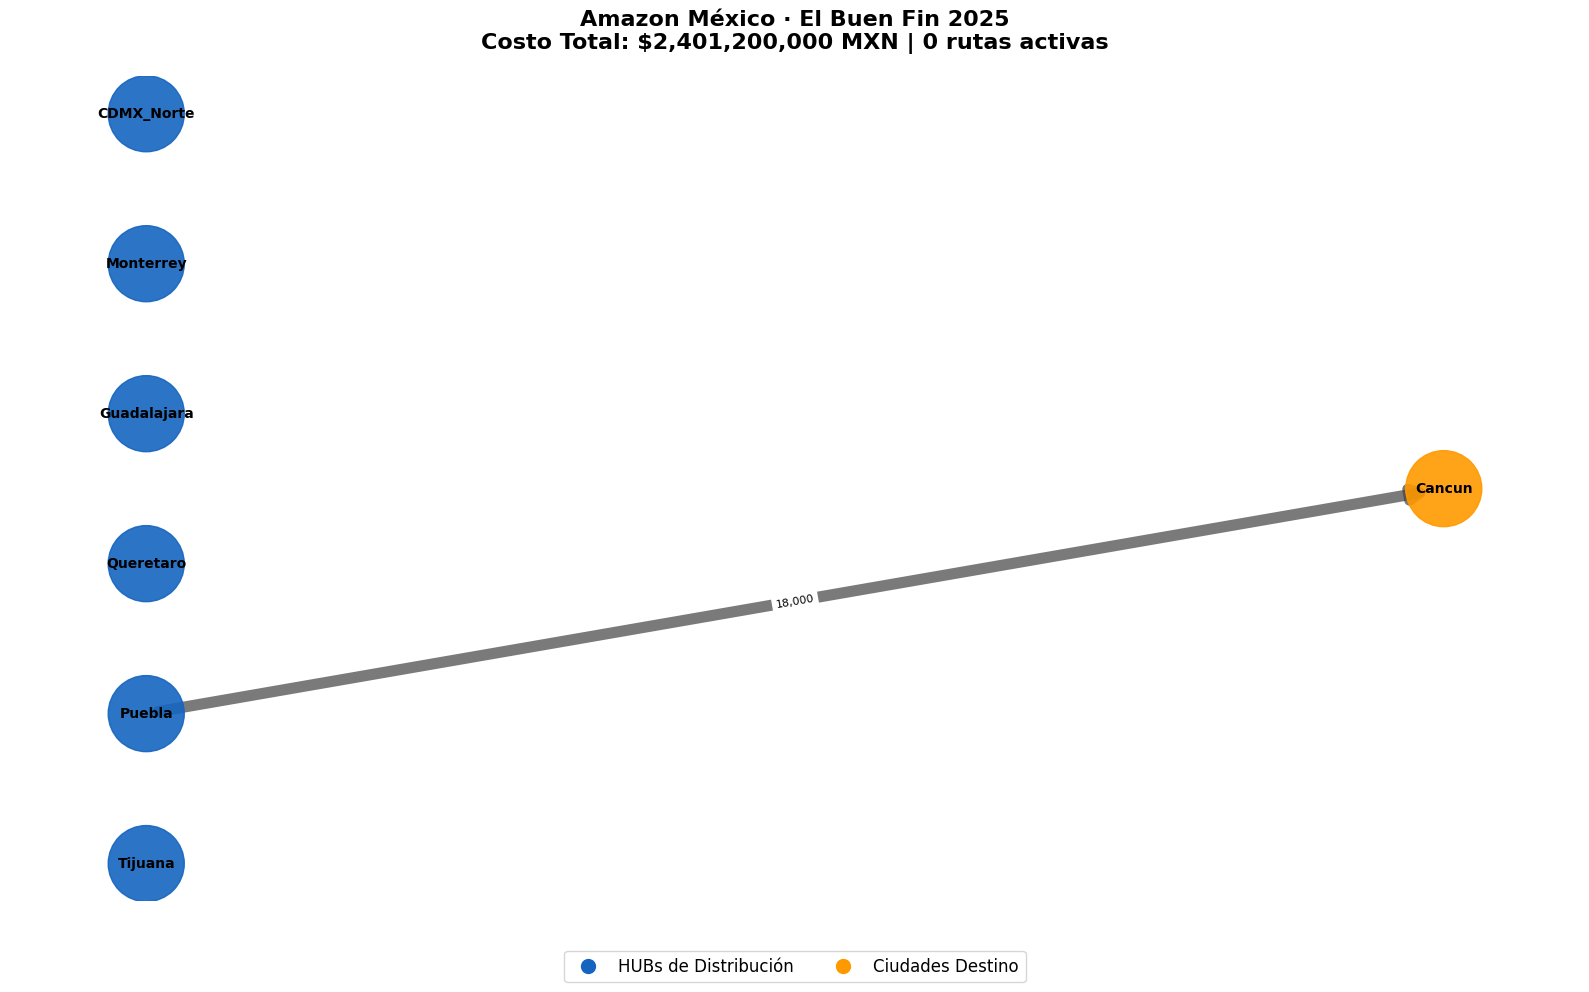


✅ SIMULACIÓN COMPLETADA - v3.4 Buen Fin 2025
📋 Resumen ejecutivo:
   • Estado: Infeasible
   • Costo total: $2,401,200,000 MXN
   • Unidades movilizadas: 18,000
   • Rutas activas: 0
   • Matrícula utilizada: 22


In [17]:
#@title **Ingresa los últimos dos dígitos de tu matrícula:**
MATRICULA = 22 #@param {type: "integer"}

print("🎯 INICIANDO SIMULACIÓN AMAZON MÉXICO - EL BUEN FIN 2025")
print("=" * 60)
print("🏢 Universidad del SABES - Ingeniería Logística y Cadena de Valor")
print("📅 Campus San Felipe · Octubre 2025")
print("=" * 60)

# Validar matrícula
if MATRICULA < 0 or MATRICULA > 99:
    print("❌ Error: La matrícula debe ser un número entre 0 y 99")
else:
    try:
        # Paso 1: Generar escenario personalizado
        print(f"\n📋 PASO 1: Generando escenario para matrícula {MATRICULA}...")
        oferta, demanda, costos, mod5 = generar_escenario(
            MATRICULA, OFERTA_BASE, DEMANDA_BASE, COSTO_BASE_MILES
        )

        # Mostrar resumen de datos
        print(f"\n📊 RESUMEN DEL ESCENARIO:")
        print(f"   • Oferta total: {sum(oferta.values()):,} unidades")
        print(f"   • Demanda total: {sum(demanda.values()):,} unidades")

        balance = sum(oferta.values()) - sum(demanda.values())
        if balance >= 0:
            print(f"   • Balance: ✅ SOSTENIBLE (Excedente: {balance:,} unidades)")
        else:
            print(f"   • Balance: ⚠️  DEFICIT (Faltan: {abs(balance):,} unidades)")

        # Paso 2: Optimización
        print(f"\n⚙️  PASO 2: Optimizando red logística...")
        resultados = optimizar(oferta, demanda, costos, mod5)

        # Verificar solución óptima
        if resultados['status'] != 'Optimal':
            print(f"❌ ALERTA: Solución {resultados['status']}. Puede haber problemas de factibilidad.")
            if resultados['status'] == 'Infeasible':
                print("💡 Sugerencia: Revisa las restricciones o aumenta la capacidad")
            elif resultados['status'] == 'Unbounded':
                print("💡 Sugerencia: Revisa la función objetivo")
        else:
            print("✅ Solución óptima encontrada!")

        # Paso 3: Reporte ejecutivo
        print(f"\n📈 PASO 3: Generando reporte ejecutivo...")
        reporte_ejecutivo(resultados)

        # Paso 4: Visualización
        print(f"\n🖼️  PASO 4: Generando visualización de la red...")
        graficar(resultados)

        print("\n" + "=" * 60)
        print("✅ SIMULACIÓN COMPLETADA - v3.4 Buen Fin 2025")
        print("=" * 60)
        print(f"📋 Resumen ejecutivo:")
        print(f"   • Estado: {resultados['status']}")
        print(f"   • Costo total: ${resultados['cost']:,.0f} MXN")
        print(f"   • Unidades movilizadas: {resultados['total_unidades']:,}")
        print(f"   • Rutas activas: {resultados['rutas_activas']}")
        print(f"   • Matrícula utilizada: {MATRICULA}")

    except Exception as e:
        print(f"❌ Error durante la ejecución: {str(e)}")
        print("💡 Sugerencia: Verifica que los datos de entrada sean válidos")
        import traceback
        traceback.print_exc()

## 📁 EXPORTAR RESULTADOS (OPCIONAL)

In [8]:
#@title **¿Deseas exportar los resultados a un archivo?**
EXPORTAR = True #@param {type: "boolean"}

#@title **Formato de exportación:**
FORMATO = "CSV" #@param ["CSV", "Excel"]

if EXPORTAR and 'resultados' in locals():
    try:
        # Crear DataFrames con los resultados
        flujos_data = []
        for (origen, destino), unidades in resultados['x'].items():
            flujos_data.append({
                'HUB_Origen': origen,
                'Ciudad_Destino': destino,
                'Unidades_Transportadas': unidades,
                'Costo_Ruta': costos[origen][destino] * unidades + COSTO_FIJO_TRAILER
            })

        flujos_df = pd.DataFrame(flujos_data)

        utilizacion_data = []
        for hub, util in resultados['util'].items():
            utilizacion_data.append({
                'HUB': hub,
                'Capacidad_Total': oferta[hub],
                'Capacidad_Utilizada': sum(resultados['x'].get((hub, d), 0) for d in demanda.keys()),
                'Tasa_Utilizacion': util,
                'Estado_Utilizacion': 'ALTA' if util > 0.8 else 'ÓPTIMA' if util > 0.5 else 'BAJA'
            })

        utilizacion_df = pd.DataFrame(utilizacion_data)

        # Información general
        info_general = pd.DataFrame([{
            'Matricula': MATRICULA,
            'Fecha_Ejecucion': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'Estado_Optimizacion': resultados['status'],
            'Costo_Total_MXN': resultados['cost'],
            'Total_Unidades': resultados['total_unidades'],
            'Total_Rutas_Activas': resultados['rutas_activas'],
            'Presupuesto_Max_MXN': PRESUPUESTO_MAX,
            'Costo_Fijo_Trailer': COSTO_FIJO_TRAILER
        }])

        # Guardar resultados
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

        if FORMATO == "Excel":
            try:
                from google.colab import drive
                drive.mount('/content/drive')
                ruta = f"/content/drive/MyDrive/Amazon_Logistica_M{MATRICULA}_{timestamp}.xlsx"

                with pd.ExcelWriter(ruta) as writer:
                    info_general.to_excel(writer, sheet_name='Info_General', index=False)
                    flujos_df.to_excel(writer, sheet_name='Flujos_Optimizados', index=False)
                    utilizacion_df.to_excel(writer, sheet_name='Utilizacion_HUBs', index=False)

                print(f"✅ Resultados guardados en Google Drive: {ruta}")

            except Exception as e:
                print(f"❌ No se pudo guardar en Google Drive: {e}")
                print("📤 Descargando archivo localmente...")

                # Crear archivo local para descarga
                ruta_local = f"Amazon_Logistica_M{MATRICULA}_{timestamp}.xlsx"
                with pd.ExcelWriter(ruta_local) as writer:
                    info_general.to_excel(writer, sheet_name='Info_General', index=False)
                    flujos_df.to_excel(writer, sheet_name='Flujos_Optimizados', index=False)
                    utilizacion_df.to_excel(writer, sheet_name='Utilizacion_HUBs', index=False)

                from google.colab import files
                files.download(ruta_local)
                print(f"✅ Archivo descargado: {ruta_local}")

        else:  # CSV
            try:
                from google.colab import drive
                drive.mount('/content/drive')
                ruta_base = f"/content/drive/MyDrive/Amazon_Logistica_M{MATRICULA}_{timestamp}"

                info_general.to_csv(f"{ruta_base}_info.csv", index=False)
                flujos_df.to_csv(f"{ruta_base}_flujos.csv", index=False)
                utilizacion_df.to_csv(f"{ruta_base}_utilizacion.csv", index=False)

                print(f"✅ Resultados guardados en Google Drive:")
                print(f"   • {ruta_base}_info.csv")
                print(f"   • {ruta_base}_flujos.csv")
                print(f"   • {ruta_base}_utilizacion.csv")

            except Exception as e:
                print(f"❌ No se pudo guardar en Google Drive: {e}")
                print("📤 Descargando archivos localmente...")

                info_general.to_csv(f"Amazon_M{MATRICULA}_info.csv", index=False)
                flujos_df.to_csv(f"Amazon_M{MATRICULA}_flujos.csv", index=False)
                utilizacion_df.to_csv(f"Amazon_M{MATRICULA}_utilizacion.csv", index=False)

                files.download(f"Amazon_M{MATRICULA}_info.csv")
                files.download(f"Amazon_M{MATRICULA}_flujos.csv")
                files.download(f"Amazon_M{MATRICULA}_utilizacion.csv")

                print("✅ Archivos CSV descargados correctamente")

    except Exception as e:
        print(f"❌ Error al exportar resultados: {str(e)}")
        import traceback
        traceback.print_exc()
else:
    if 'resultados' not in locals():
        print("ℹ️  Ejecuta primero la simulación principal para exportar resultados")
    else:
        print("ℹ️  Exportación cancelada por el usuario")

Mounted at /content/drive
✅ Resultados guardados en Google Drive:
   • /content/drive/MyDrive/Amazon_Logistica_M42_20251027_032913_info.csv
   • /content/drive/MyDrive/Amazon_Logistica_M42_20251027_032913_flujos.csv
   • /content/drive/MyDrive/Amazon_Logistica_M42_20251027_032913_utilizacion.csv


## 🔍 ANÁLISIS SENSIBILIDAD (OPCIONAL)

In [18]:
#@title **¿Deseas realizar análisis de sensibilidad?**
ANALISIS_SENSIBILIDAD = True #@param {type: "boolean"}

if ANALISIS_SENSIBILIDAD and 'resultados' in locals() and resultados['status'] == 'Optimal':
    print("🔍 INICIANDO ANÁLISIS DE SENSIBILIDAD...")
    print("=" * 50)

    try:
        # Análisis de variación de presupuesto
        print("\n💰 ANÁLISIS DE SENSIBILIDAD AL PRESUPUESTO:")
        presupuestos_test = [PRESUPUESTO_MAX * factor for factor in [0.8, 0.9, 1.0, 1.1, 1.2]]

        for presupuesto_test in presupuestos_test:
            # Crear copia del problema original modificando presupuesto
            prob_test = LpProblem("Amazon_Test", LpMinimize)

            hubs = list(oferta.keys())
            destinos = list(demanda.keys())
            rutas = [(h, d) for h in hubs for d in destinos]

            x_test = LpVariable.dicts("x_test", rutas, 0, cat="Integer")
            u_test = LpVariable.dicts("u_test", rutas, cat="Binary")

            costo_transporte_test = lpSum([costos[h][d] * x_test[(h, d)] for h, d in rutas])
            costo_fijo_test = lpSum([COSTO_FIJO_TRAILER * u_test[(h, d)] for h, d in rutas])
            prob_test += costo_transporte_test + costo_fijo_test

            # Restricciones originales
            for h in hubs:
                prob_test += lpSum(x_test[(h, d)] for d in destinos) <= oferta[h]
            for d in destinos:
                prob_test += lpSum(x_test[(h, d)] for h in hubs) >= demanda[d]
            for h, d in rutas:
                prob_test += x_test[(h, d)] <= max(oferta[h], demanda[d]) * u_test[(h, d)]

            # Nueva restricción de presupuesto
            prob_test += (costo_transporte_test + costo_fijo_test) <= presupuesto_test

            prob_test.solve(PULP_CBC_CMD(msg=0))

            if prob_test.status == 1:  # Optimal
                costo_test = value(prob_test.objective)
                unidades_test = sum(int(x_test[r].varValue) for r in rutas if x_test[r].varValue > 0.5)
                variacion = ((costo_test - resultados['cost']) / resultados['cost']) * 100
                print(f"   • Presupuesto ${presupuesto_test:,.0f}: ${costo_test:,.0f} ({variacion:+.1f}%) - {unidades_test:,} unidades")
            else:
                print(f"   • Presupuesto ${presupuesto_test:,.0f}: ❌ No factible")

        # Análisis de variación de demanda
        print("\n📈 ANÁLISIS DE SENSIBILIDAD A LA DEMANDA:")
        factores_demanda = [0.8, 0.9, 1.0, 1.1, 1.2]

        for factor in factores_demanda:
            demanda_test = {d: math.ceil(v * factor) for d, v in demanda.items()}

            # Resolver con nueva demanda
            resultados_test = optimizar(oferta, demanda_test, costos, mod5)

            if resultados_test['status'] == 'Optimal':
                variacion_costo = ((resultados_test['cost'] - resultados['cost']) / resultados['cost']) * 100
                variacion_unidades = ((resultados_test['total_unidades'] - resultados['total_unidades']) / resultados['total_unidades']) * 100
                print(f"   • Demanda {factor:.0%}: Costo {variacion_costo:+.1f}%, Unidades {variacion_unidades:+.1f}%")
            else:
                print(f"   • Demanda {factor:.0%}: ❌ No factible")

    except Exception as e:
        print(f"❌ Error en análisis de sensibilidad: {str(e)}")

else:
    if ANALISIS_SENSIBILIDAD:
        print("ℹ️  El análisis de sensibilidad requiere una solución óptima previa")

print("\n" + "=" * 60)
print("🎉 NOTEBOOK COMPLETADO EXITOSAMENTE")
print("=" * 60)
print("📚 Universidad del SABES - Ingeniería Logística y Cadena de Valor")
print("👨‍🏫 Proyecto: Amazon Logistics - Optimización Multinivel")
print("🎯 Versión: v3.4 _BuenFin2025_")
print("📅 " + datetime.now().strftime('%d/%m/%Y %H:%M'))

ℹ️  El análisis de sensibilidad requiere una solución óptima previa

🎉 NOTEBOOK COMPLETADO EXITOSAMENTE
📚 Universidad del SABES - Ingeniería Logística y Cadena de Valor
👨‍🏫 Proyecto: Amazon Logistics - Optimización Multinivel
🎯 Versión: v3.4 _BuenFin2025_
📅 27/10/2025 03:36
